In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files

In [2]:
beijing = pd.read_csv('Beijing.csv')

<ipython-input-3-8bbf788a215c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(beijing, x='value', y='unit', inner='box', palette='Dark2')


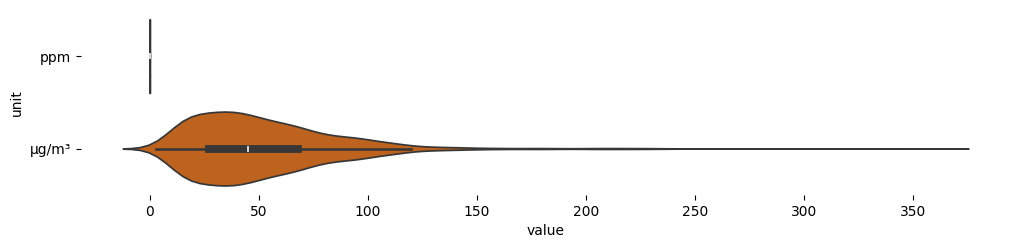

In [3]:
# @title unit vs value

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(beijing['unit'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(beijing, x='value', y='unit', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [4]:
beijing['datetimeLocal'] = pd.to_datetime(beijing['datetimeLocal'], errors='coerce')

# Drop rows with invalid datetime values
beijing = beijing.dropna(subset=['datetimeLocal'])

# Convert datetime to timestamp (seconds since epoch)
beijing['timestamp'] = beijing['datetimeLocal'].astype(int) / 1e9  # Convert nanoseconds to seconds

beijing.head()


,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider,timestamp
0,8833,Beijing,o3,0.033,ppm,2024-03-01T01:00:00+00:00,2024-03-01 09:00:00+08:00,Asia/Shanghai,39.953352,116.466258,NaN,NaN,NaN,Unknown Governmental Organization,AirNow,1.709255e+09
1,8833,Beijing,o3,0.038,ppm,2024-03-01T02:00:00+00:00,2024-03-01 10:00:00+08:00,Asia/Shanghai,39.953352,116.466258,NaN,NaN,NaN,Unknown Governmental Organization,AirNow,1.709258e+09
2,8833,Beijing,o3,0.037,ppm,2024-03-01T03:00:00+00:00,2024-03-01 11:00:00+08:00,Asia/Shanghai,39.953352,116.466258,NaN,NaN,NaN,Unknown Governmental Organization,AirNow,1.709262e+09
3,8833,Beijing,o3,0.036,ppm,2024-03-01T04:00:00+00:00,2024-03-01 12:00:00+08:00,Asia/Shanghai,39.953352,116.466258,NaN,NaN,NaN,Unknown Governmental Organization,AirNow,1.709266e+09
4,8833,Beijing,o3,0.036,ppm,2024-03-01T05:00:00+00:00,2024-03-01 13:00:00+08:00,Asia/Shanghai,39.953352,116.466258,NaN,NaN,NaN,Unknown Governmental Organization,AirNow,1.709269e+09


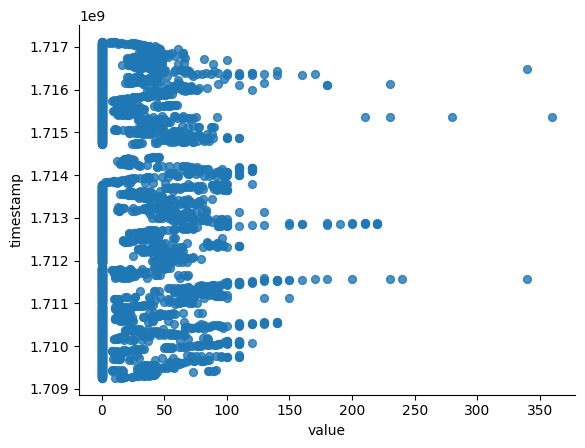

In [5]:
# @title value vs timestamp

from matplotlib import pyplot as plt
beijing.plot(kind='scatter', x='value', y='timestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Linear Regression:
  Mean Squared Error: 1476.09
  R-squared: 0.01
Ridge Regression:
  Mean Squared Error: 1476.11
  R-squared: 0.01
Gradient Boosting:
  Mean Squared Error: 1347.24
  R-squared: 0.09
Cross-validated R-squared: -5.34


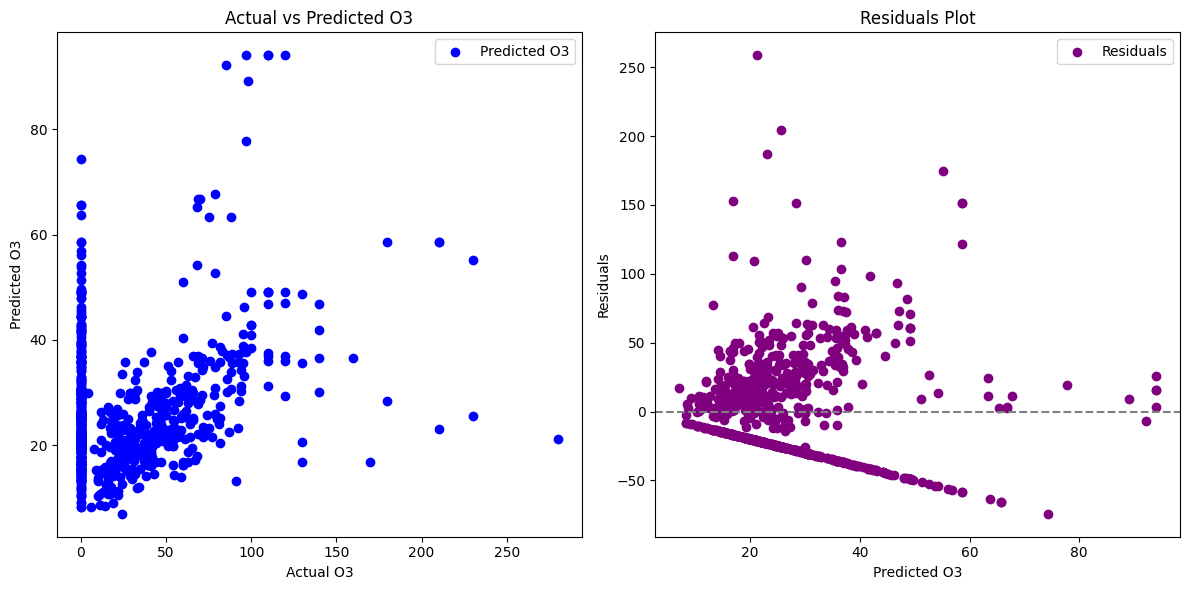

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



# Convert the datetimeLocal column to datetime format
beijing['datetimeLocal'] = pd.to_datetime(beijing['datetimeLocal'], errors='coerce')

# Drop rows with missing values in datetimeLocal or value
beijing.dropna(subset=['datetimeLocal', 'value'], inplace=True)

# Extract additional features from datetime
beijing['timestamp'] = beijing['datetimeLocal'].astype(int) / 1e9  # Convert nanoseconds to seconds
beijing['day_of_week'] = beijing['datetimeLocal'].dt.dayofweek
beijing['hour'] = beijing['datetimeLocal'].dt.hour
beijing['month'] = beijing['datetimeLocal'].dt.month

# Select features and target
features = ['timestamp', 'day_of_week', 'hour', 'month']
target = 'value'

X = beijing[features]
y = beijing[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

best_model = None
best_score = float('-inf')

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'{name}:')
    print(f'  Mean Squared Error: {mse:.2f}')
    print(f'  R-squared: {r2:.2f}')

    # Track the best model
    if r2 > best_score:
        best_score = r2
        best_model = model

# Cross-validation score for the best model
cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f'Cross-validated R-squared: {cv_scores.mean():.2f}')

# Plot actual vs predicted values for the best model
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(12, 6))

# Plot actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue', label='Predicted O3')
plt.xlabel('Actual O3')
plt.ylabel('Predicted O3')
plt.title('Actual vs Predicted O3')
plt.legend()

# Plot residuals
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, color='purple', label='Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Predicted O3')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()

plt.tight_layout()
plt.show()


Linear Regression:
  Mean Squared Error: 1476.09
  R-squared: 0.01
Ridge Regression:
  Mean Squared Error: 1476.11
  R-squared: 0.01
Gradient Boosting:
  Mean Squared Error: 1347.24
  R-squared: 0.09
Cross-validated R-squared: -5.34


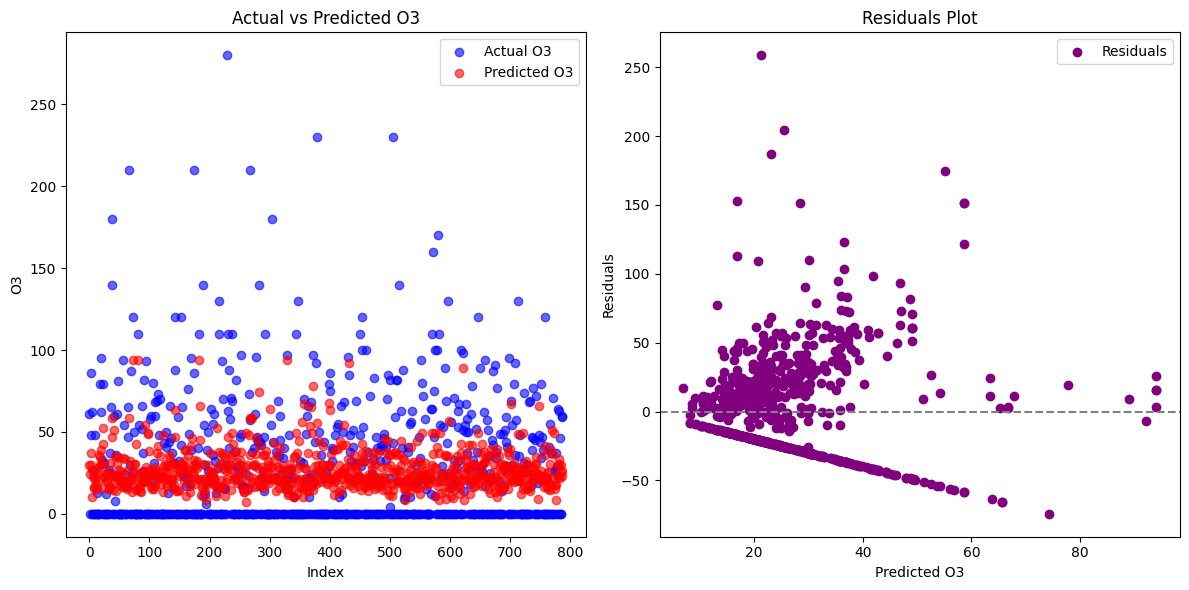

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Convert the datetimeLocal column to datetime format
beijing['datetimeLocal'] = pd.to_datetime(beijing['datetimeLocal'], errors='coerce')

# Drop rows with missing values in datetimeLocal or value
beijing.dropna(subset=['datetimeLocal', 'value'], inplace=True)

# Extract additional features from datetime
beijing['timestamp'] = beijing['datetimeLocal'].astype(int) / 1e9  # Convert nanoseconds to seconds
beijing['day_of_week'] = beijing['datetimeLocal'].dt.dayofweek
beijing['hour'] = beijing['datetimeLocal'].dt.hour
beijing['month'] = beijing['datetimeLocal'].dt.month

# Select features and target
features = ['timestamp', 'day_of_week', 'hour', 'month']
target = 'value'

X = beijing[features]
y = beijing[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

best_model = None
best_score = float('-inf')

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'{name}:')
    print(f'  Mean Squared Error: {mse:.2f}')
    print(f'  R-squared: {r2:.2f}')

    # Track the best model
    if r2 > best_score:
        best_score = r2
        best_model = model

# Cross-validation score for the best model
cv_scores = cross_val_score(best_model, X, y, cv=5)
print(f'Cross-validated R-squared: {cv_scores.mean():.2f}')

# Plot actual vs predicted values for the best model
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(12, 6))

# Scatter plot for actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual O3', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted O3', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('O3')
plt.title('Actual vs Predicted O3')
plt.legend()

# Plot residuals
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, color='purple', label='Residuals')
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Predicted O3')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()

plt.tight_layout()
plt.show()
